<h1 align="center"> ФМИ. Disbalanced dataset.  Part 2 </h1>
<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данном семинаре мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные.</li>
<li> Решить проблему сильного дисбаланса классов.  </li>
<li>Построить модели на основе классических алгоритмов машинного обучения. </li>
<li> Провести сравнительный анализ классических подходов.</li>

## Описание данных и постановка задачи:
**Задача:** см ФМИ. Disbalanced dataset.Part 1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем данные.

In [ ]:
# Будем загружать данные, полученные в предыдущем блокноте.
# См обновленный блокнот

new_df = pd.read_csv('/content/drive/MyDrive/26.11.24/Spotifyyy_757.csv')
new_df.drop(columns=['Unnamed: 0'], inplace=True)

new_df.head()

,artists,acousticness,instrumentalness,valence,mmpopularity,track_genre
0,1147,0.58100,0.000013,0.413,0.47,4
1,957,0.18100,0.000039,0.483,0.45,2
2,231,0.92000,0.000000,0.361,0.52,0
3,978,0.00159,0.793000,0.673,0.45,2
4,2062,0.81300,0.000006,0.133,0.23,7


In [ ]:
new_df.describe()

,artists,acousticness,instrumentalness,valence,mmpopularity,track_genre
count,6813.000000,6813.000000,6813.000000,6813.000000,6813.000000,6813.000000
mean,1229.678409,0.347045,0.214005,0.466258,0.325670,4.000000
std,721.221597,0.354187,0.349021,0.274790,0.227839,2.582178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,685.000000,0.012900,0.000000,0.224000,0.170000,2.000000
50%,1169.000000,0.204000,0.000494,0.448000,0.290000,4.000000
75%,1859.000000,0.692000,0.363000,0.693000,0.510000,6.000000
max,2513.000000,0.996000,0.988000,0.988000,0.930000,8.000000


In [ ]:
new_df.track_genre.value_counts()

,count
track_genre,
4,757
2,757
0,757
7,757
6,757
1,757
3,757
8,757
5,757


<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [ ]:
'''
Работаем с маленьким датасетом new_df
Делаем из него 2 набора.
В первом - все столбцы, но нет целевой переменной.
Во втором - столбец с целевой переменной.
'''


X = new_df.drop('track_genre', axis=1)
y = new_df['track_genre']

In [ ]:
# Про масштабирование мы с вами уже в курсе. Опять используем RobustScaler

from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (artists)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,
                                                    stratify = y)

X_train['scaled_artists'] = rob_scaler.fit_transform(X_train['artists'].values.reshape(-1,1))
X_test['scaled_artists'] = rob_scaler.fit_transform(X_test['artists'].values.reshape(-1,1))

# удаляем из трейн и тест датасетов  столбцы artists,
# так как у нас уже есть их отмасштабированные версии
X_train.drop(['artists'], axis=1, inplace=True)
X_test.drop(['artists'], axis=1, inplace=True)

In [ ]:
# Переводим данные в массив для подачи в классификатор
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
X_test

array([[ 1.31000000e-06,  7.66000000e-01,  3.93000000e-02,
         2.00000000e-01,  5.86805556e-01],
       [ 3.36000000e-02,  0.00000000e+00,  5.23000000e-01,
         1.00000000e-02, -3.42013889e-01],
       [ 4.63000000e-03,  8.82000000e-01,  6.42000000e-01,
         1.80000000e-01, -6.84027778e-01],
       ...,
       [ 4.67000000e-01,  1.86000000e-06,  1.67000000e-01,
         0.00000000e+00, -2.92534722e-01],
       [ 8.31000000e-01,  6.44000000e-06,  9.29000000e-01,
         3.20000000e-01, -8.43750000e-01],
       [ 9.54000000e-01,  1.49000000e-06,  3.08000000e-01,
         0.00000000e+00, -3.33333333e-01]])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Выберем несколько простых моделей из библиотеки sklearn

classifiers = {
    "LogisiticRegression": LogisticRegression(),  # Логистическая регрессия
    "KNearest": SVC(),  # Метод опорных векторов
    "Support Vector Classifier": KNeighborsClassifier(),# Метод ближайших соседей
    "DecisionTreeClassifier": DecisionTreeClassifier() # Решающее дерево
}

Для борьбы с переобучением будем использовать кросс-валидацию.

<img src="https://scikit-learn.ru/wp-content/uploads/2021/10/image-161.png" width=800>

Разобьем обучающую выборку на 5 фолдов и обучим наши модели.

In [ ]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    #classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Модель ", classifier.__class__.__name__, "получила на обучающей выборке", round(training_score.mean(), 2) * 100, "% accuracy score")

Модель  LogisticRegression получила на обучающей выборке 73.0 % accuracy score
Модель  SVC получила на обучающей выборке 89.0 % accuracy score
Модель  KNeighborsClassifier получила на обучающей выборке 86.0 % accuracy score
Модель  DecisionTreeClassifier получила на обучающей выборке 88.0 % accuracy score


Для улучшения качества моделей переберем по сетке различные гиперпараметры методом GridSearchCV.


In [ ]:
# Используем поиск по сетке для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV

# Логистическая регрессия
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# Выбираем лучшую модель
log_reg = grid_log_reg.best_estimator_ #  для Логистическая регрессия

# Метод ближайших соседей
knears_params = {"n_neighbors": list(range(2,7,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_# для  K ближайший соседей

# Метод опорных векторов
x = [1.0, 1000.0]
y = [0.9]
z = [4]
svc_params=[
            {'C': x,'kernel': ['rbf'],'gamma': y} ,
            {'C': x,'kernel': ['poly'],'gamma': y,'degree': z}
           ]
grid_svc=GridSearchCV(estimator = SVC(),
                        param_grid = svc_params,
                        scoring='accuracy',
                        cv=3,
                        n_jobs=-1)

grid_svc.fit(X_train, y_train)

svc = grid_svc.best_estimator_#  для SVM

# Решающее дерево
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,7,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree_clf = grid_tree.best_estimator_#  для решающий деревьев

In [ ]:
# Проверим, как поменялись метрики

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  76.35%
Knears Neighbors Cross Validation Score 86.66%
Support Vector Classifier Cross Validation Score 89.78%
DecisionTree Classifier Cross Validation Score 92.04%


Для 3 из 4 метрик Видим явное улучшение!

Давайте теперь попробуем более умные способы undersampling. Например, с помощью NearMiss, который оценивает среднее расстояние между классами. Поможет нам в этом специальная библиотека для работы с несбалансированными даннными imblearn.

In [ ]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

from sklearn.metrics import (precision_score, roc_auc_score, recall_score, f1_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve, accuracy_score)

undersample_X = new_df.drop('track_genre', axis=1)
undersample_y = new_df['track_genre']

undersample_Xtrain, undersample_Xtest, undersample_ytrain, undersample_ytest = train_test_split(undersample_X, undersample_y,
                                                                                                test_size = 0.2,
                                                                                                random_state=42,
                                                                                                stratify = undersample_y)#

undersample_Xtest['scaled_artists'] = rob_scaler.fit_transform(undersample_Xtest['artists'].values.reshape(-1,1))#

undersample_Xtrain.drop(['artists'], axis=1, inplace=True)
undersample_Xtest.drop(['artists'], axis=1, inplace=True)

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Метод NearMiss
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss распределение классов: {}'.format(Counter(y_nearmiss)))
# Использовать сэмплирование будем во время кросс-валидации

for train, test in skf.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)#
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])#
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])#
    undersample_prediction_proba = undersample_model.predict_proba(undersample_Xtrain[test])#

    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test],
                                                           undersample_ytrain[test]))
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction, average='macro'))
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction, average='macro'))
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction, average='macro'))
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction_proba, multi_class='ovr'))
    # undersample_auc.append(roc_auc_score_multiclass(undersample_ytrain[test], undersample_prediction))

NearMiss распределение классов: Counter({0: 757, 1: 757, 2: 757, 3: 757, 4: 757, 5: 757, 6: 757, 7: 757, 8: 757})


In [ ]:
len(undersample_prediction)

1090

In [ ]:
len(undersample_ytrain[test])

1090

Построим кривую обучение каждой из модели. Данная кривая показывает различие между метриками во время обычного обучения и во время кросс-валидации.

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import seaborn as sn

In [ ]:
def plot_learning_curves(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # Первая модель
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)#
    train_scores_mean = np.mean(train_scores, axis=1)#
    train_scores_std = np.std(train_scores, axis=1)#
    test_scores_mean = np.mean(test_scores, axis=1)#
    test_scores_std = np.std(test_scores, axis=1)#
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Размер выборки')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Вторая модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Размер выборки')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")


    # Третья модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Размер выборки')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")


    # Четвертая модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Размер выборки')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

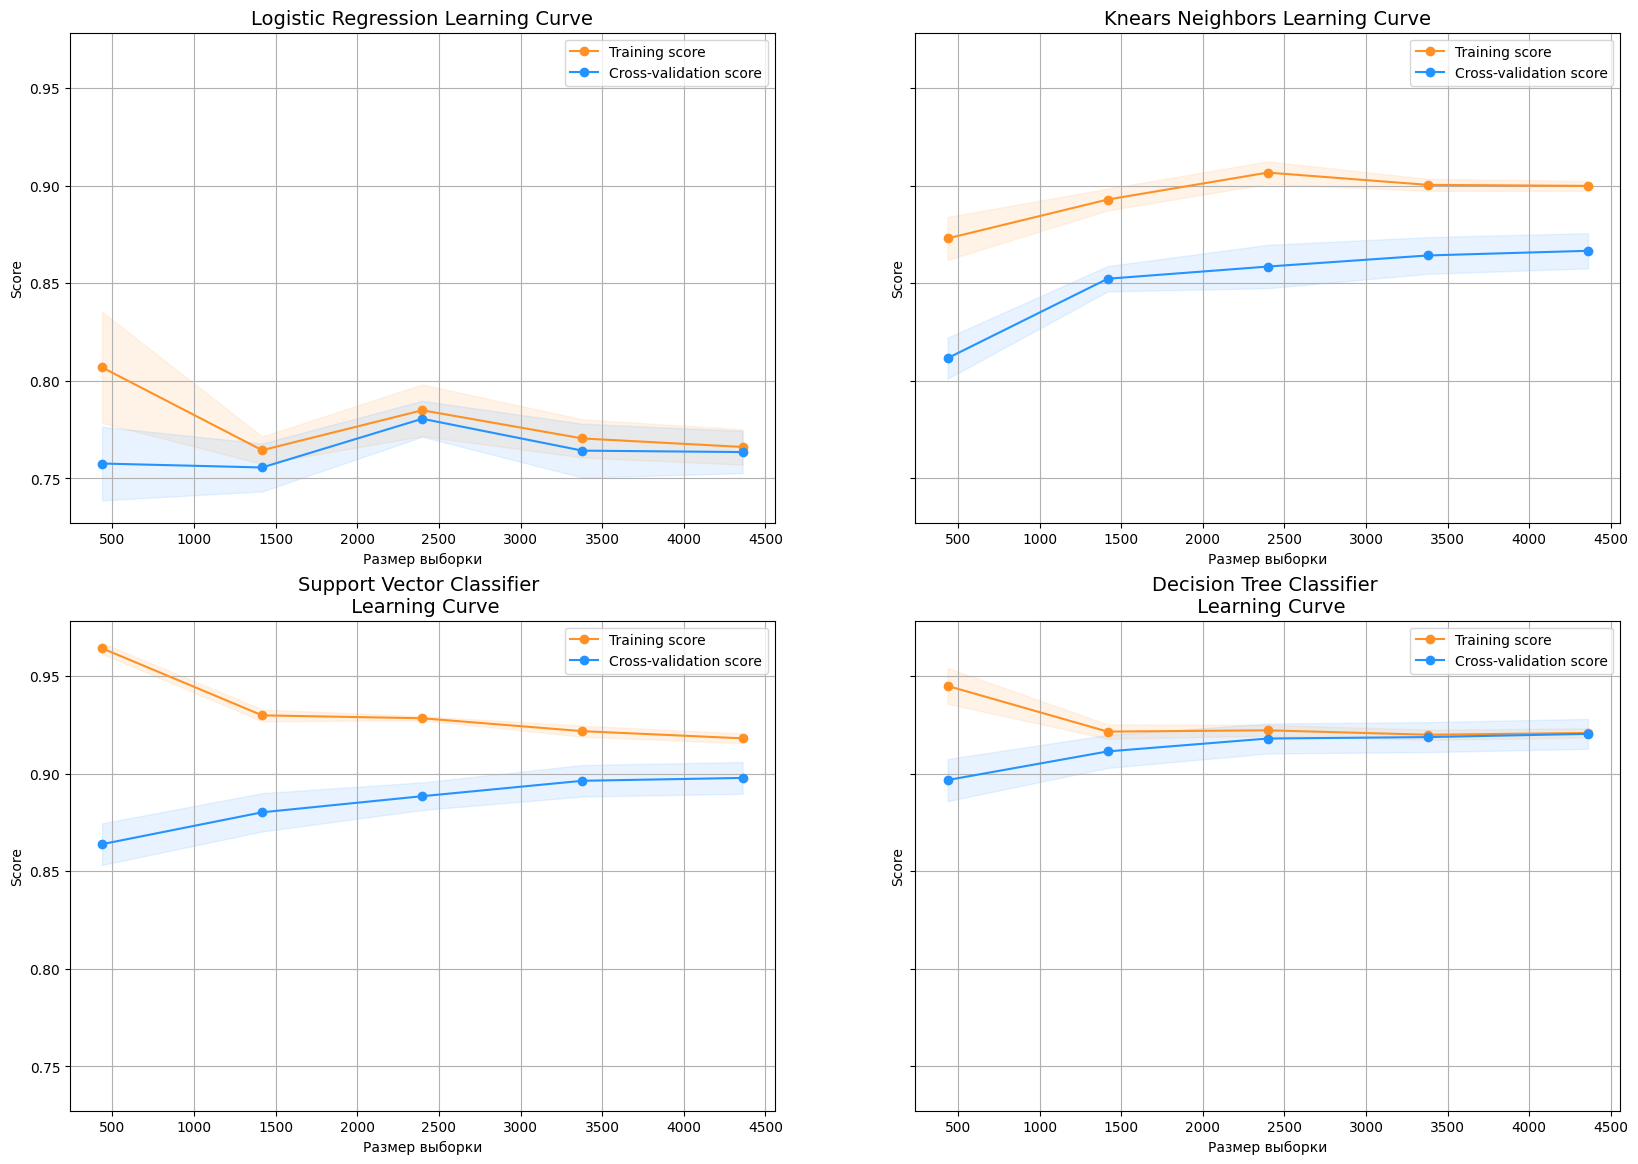

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curves(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train)

## Кривые обучения:
<ul>
<li>Чем больше разрыв между результатами обучения и результатами кросс-валидации, тем больше вероятность того, что модель переобучилась (большой разброс).</li>
<li> Если результаты низкие как на обучающем, так и на кросс-валидационном наборе, это указывает на то, что наша модель недообучилась (большое смещение).</li>
<li>Decision Tree Classifier показала себя лучше остальных.</li>
</ul>

In [ ]:
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                              method='predict_proba')

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5, method='predict_proba')

# svc_pred = cross_val_predict(svc, X_train, y_train, cv=5)

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5, method='predict_proba')

In [ ]:
log_reg_pred

array([[3.53499350e-29, 2.27304534e-13, 7.45444401e-04, ...,
        4.30350831e-03, 2.23723797e-02, 1.44385544e-03],
       [3.95618698e-47, 1.56337139e-23, 7.51874575e-07, ...,
        3.47105320e-01, 1.45203667e-01, 4.14315405e-01],
       [5.49015037e-10, 2.49641657e-02, 5.60638303e-01, ...,
        4.55400984e-03, 5.06526705e-05, 1.03202319e-05],
       ...,
       [6.32089608e-03, 9.93633754e-01, 4.15055216e-05, ...,
        5.34997429e-12, 2.30745463e-11, 3.91835092e-13],
       [2.76315052e-11, 5.35611471e-04, 5.36595258e-01, ...,
        8.71434159e-06, 1.34389536e-04, 5.95200414e-05],
       [1.58239513e-12, 2.93574024e-04, 4.85632431e-01, ...,
        3.56173739e-05, 3.61425261e-04, 1.48697217e-04]])

In [ ]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred, multi_class="ovo"))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred, multi_class="ovo"))
# print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred, multi_class="ovo"))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred, multi_class="ovo"))

Logistic Regression:  0.9683945805146986
KNears Neighbors:  0.9785714001337757
Decision Tree Classifier:  0.9911421913800051


Построим roc-кривую и посчитаем площадь под ней. (для мультиклассовой нельзя)

In [ ]:
# from sklearn.preprocessing import label_binarize
# # log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)#

# # knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)#
# # svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)#
# # tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)#


# def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
#     plt.figure(figsize=(16,8))
#     plt.title('ROC Curve', fontsize=18)
#     plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
#     plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
#     # plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
#     plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.axis([-0.01, 1, 0, 1])
#     plt.xlabel('False Positive Rate', fontsize=16)
#     plt.ylabel('True Positive Rate', fontsize=16)
#     plt.legend()

# graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr)
# plt.show()

### SMOTE метод (Over-Sampling):

<b>SMOTE</b> означает Synthetic Minority Over-sampling Technique.  В отличие от Random Under-Sampling, SMOTE создает новые синтетические точки для того, чтобы создать баланс классов. Это еще одна альтернатива для решения проблемы дисбаланса классов. <br><br>


<b> Принцип работы SMOTE: </b>
<ul>
<li><b>Генерация синтетических точек: </b> SMOTE выбирает расстояние между ближайшими соседями меньшего класса и между ними создает синтетические точки. </li>
<li> <b>Преимущество:  </b> Сохраняется больше информации, поскольку нам не пришлось удалять данные, в отличие от under-sampling.</li>
</ul>

### Правильное использование SMOTE
Если мы создадим синтетические точки перед кросс-валидацией, мы окажем определенное влияние на тестовое выборку. Но тестовая выборка не должна быть тронута! По этой причине мы должны создавать синтетические точки данных во время кросс-валидации, а не до нее.

Попробуем в качестве алгоритм подбора гиперпараметров случайный поиск. Он работает быстрее, чем поиск по сетке.

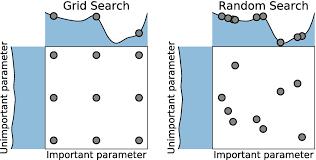

In [ ]:
# Будем загружать данные, полученные в предыдущем блокноте.
# См обновленный блокнот

new_df = pd.read_csv('/content/drive/MyDrive/20.11.24/Spotifyy5.csv')
new_df.drop(columns=['Unnamed: 0'], inplace=True)

new_df.head()

,artists,acousticness,instrumentalness,valence,mmpopularity,track_genre
0,0,0.0322,0.000001,0.715,0.73,0
1,1,0.9240,0.000006,0.267,0.55,0
2,2,0.2100,0.000000,0.120,0.57,0
3,3,0.9050,0.000071,0.143,0.71,0
4,4,0.4690,0.000000,0.167,0.82,0


In [ ]:
new_df.track_genre.value_counts()

,count
track_genre,
7,989
0,985
1,985
2,982
3,980
6,978
5,960
4,905
8,757


In [ ]:
# Берем кусок кода из предыдущего блокнота



from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = new_df.drop('track_genre', axis=1)
y = new_df['track_genre']
# print(X)
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


original_Xtrain['scaled_artists'] = rob_scaler.fit_transform(original_Xtrain['artists'].values.reshape(-1,1))
original_Xtest['scaled_artists'] = rob_scaler.fit_transform(original_Xtest['artists'].values.reshape(-1,1))

original_Xtrain.drop(['artists'], axis=1, inplace=True)
original_Xtest.drop(['artists'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Распределение классов: 

Обучающий набор: [0.11458333 0.11326291 0.11693075 0.11927817 0.10504695 0.1131162
 0.11106221 0.11561033 0.09110915]
Тестовый набор: [0.11964809 0.12492669 0.1085044  0.09794721 0.11085044 0.11085044
 0.12961877 0.11788856 0.0797654 ]


In [ ]:
# сохраним параметры наших классификаторов, на которых они показали лучших результат с GridSearchCV

#dictionary of classifiers objects which we got in the above cell via GridSearchCV
#with the tuned parameters
tuned_classifiers = {
    "LogisiticRegression": log_reg,
    "Knears Neighbors": knears_neighbors,
    # "Support Vector Classifier": svc,
    "DecisionTreeClassifier": tree_clf
}

#Making our Classifiers train with the tuned parameters
for key, classifier in tuned_classifiers.items():
    score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(f'{key} Cross Validation Score: {round(score.mean() * 100, 2)}%')

LogisiticRegression Cross Validation Score: 76.35%
Knears Neighbors Cross Validation Score: 86.66%
DecisionTreeClassifier Cross Validation Score: 92.04%


In [ ]:
Counter(new_df.track_genre.value_counts())

Counter({989: 1, 985: 2, 982: 1, 980: 1, 978: 1, 960: 1, 905: 1, 757: 1})

In [ ]:
#Over Sampling and under sampling libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Machine learning Pipeline libraries
from imblearn.pipeline import Pipeline



# here we are using the imbalanced dataset

X = new_df.drop('track_genre', axis=1)
y = new_df['track_genre']


y_nearmiss = Counter(new_df.track_genre)
# print('NearMiss распределение классов: {}'.format(Counter(new_df.track_genre)))


# StratifiedKFold is used for cross validation
# This cross-validation object is a variation of KFold that returns stratified folds.
# The folds are made by preserving the percentage of samples for each class.
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
print(sss)
# creating the object for Over Sampling the minority class
over = SMOTE(sampling_strategy=Counter(y_nearmiss),k_neighbors=5)
print(over)
# creating the object for Under Sampling the majority class
under = RandomUnderSampler(sampling_strategy=Counter(y_nearmiss))
print(under)
# iterating thru the dictionary of tuned classifiers
for key, classifier in tuned_classifiers.items():

    # list of steps to be provided to the ML Pipeline
    steps=[('o',over),('u',under),('model',classifier)]

    # Creating a ML Pipeline
    FiPipeline=Pipeline(steps=steps)
    print(FiPipeline)
    # Cross validating the classifiers
    scores=cross_val_score(FiPipeline,X,y,cv=sss, error_score='raise')

    # Printing the mean accuracy score
    print(f"Classifiers: {key} Has a training score of, {round(scores.mean() * 100, 2)} % accuracy score")

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
SMOTE(sampling_strategy=Counter({7: 989, 0: 985, 1: 985, 2: 982, 3: 980, 6: 978,
                                 5: 960, 4: 905, 8: 757}))
RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985, 1: 985, 2: 982,
                                              3: 980, 6: 978, 5: 960, 4: 905,
                                              8: 757}))
Pipeline(steps=[('o',
                 SMOTE(sampling_strategy=Counter({7: 989, 0: 985, 1: 985,
                                                  2: 982, 3: 980, 6: 978,
                                                  5: 960, 4: 905, 8: 757}))),
                ('u',
                 RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985,
                                                               1: 985, 2: 982,
                                                               3: 980, 6: 978,
                                                               5: 960, 4: 905,


# Logistic Regression

In [ ]:
# taking a fold of a data to do GridSearchCV for best parameters for SMOTE
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# creating a ML pipeline
model = Pipeline([
        ('sampling', SMOTE(sampling_strategy=Counter(y_nearmiss))),
        ('Random',RandomUnderSampler(sampling_strategy=Counter(y_nearmiss))),
        ('classification', log_reg)
    ])

# Running GridSearchCV on our ML pipeline by varying the k_neighbors from 1 to 10
# to find the best k_neighbors parameter value
# NOTE :- in paramgrid use above key + 2 _ followed by parameter
SMOTE_LNR = GridSearchCV(model,{'sampling__k_neighbors':list(range(1,10))})
SMOTE_LNR.fit(original_Xtrain,original_ytrain)

print(SMOTE_LNR.best_estimator_)
print(SMOTE_LNR.best_score_)
print(SMOTE_LNR.best_params_)

# Training logistic regression classifier using SMOTE best parameter value for k_neighbors parameter
log_reg_score = cross_val_score(SMOTE_LNR.best_estimator_, original_Xtrain, original_ytrain, cv=5)

# printing the mean accuracy score
print(f'Logistic Regression Cross Validation Score: {round(log_reg_score.mean() * 100, 2)}%')

Pipeline(steps=[('sampling',
                 SMOTE(k_neighbors=3,
                       sampling_strategy=Counter({7: 989, 0: 985, 1: 985,
                                                  2: 982, 3: 980, 6: 978,
                                                  5: 960, 4: 905, 8: 757}))),
                ('Random',
                 RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985,
                                                               1: 985, 2: 982,
                                                               3: 980, 6: 978,
                                                               5: 960, 4: 905,
                                                               8: 757}))),
                ('classification', LogisticRegression(C=100))])
0.7265677746389175
{'sampling__k_neighbors': 3}
Logistic Regression Cross Validation Score: 71.75%


In [ ]:
labels = np.char.mod('%d', np.arange(9))

best_est_LNR = SMOTE_LNR.best_estimator_
smote_prediction = best_est_LNR.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88       197
           1       0.80      0.82      0.81       197
           2       0.48      0.55      0.51       196
           3       0.55      0.46      0.50       196
           4       0.72      0.81      0.76       181
           5       0.58      0.51      0.54       192
           6       0.76      0.93      0.84       196
           7       0.58      0.76      0.66       197
           8       0.57      0.34      0.43       152

    accuracy                           0.67      1704
   macro avg       0.67      0.66      0.66      1704
weighted avg       0.67      0.67      0.66      1704



In [ ]:
best_est_LNR

Pipeline(steps=[('sampling',
                 SMOTE(k_neighbors=3,
                       sampling_strategy=Counter({7: 989, 0: 985, 1: 985,
                                                  2: 982, 3: 980, 6: 978,
                                                  5: 960, 4: 905, 8: 757}))),
                ('Random',
                 RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985,
                                                               1: 985, 2: 982,
                                                               3: 980, 6: 978,
                                                               5: 960, 4: 905,
                                                               8: 757}))),
                ('classification', LogisticRegression(C=100))])

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Применим SMOTE после кросс-валидации
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# Обучим логистическую регрессию
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Время обучения: {} сек".format(t1 - t0))

Время обучения: 0.2896273136138916 сек


# knears_neighbors

In [ ]:
# taking a fold of a data to do GridSearchCV for best parameters for SMOTE
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# creating a ML pipeline
model = Pipeline([
        ('sampling', SMOTE(sampling_strategy=Counter(y_nearmiss))),
        ('Random',RandomUnderSampler(sampling_strategy=Counter(y_nearmiss))),
        ('classification', knears_neighbors)
    ])

# Running GridSearchCV on our ML pipeline by varying the k_neighbors from 1 to 10
# to find the best k_neighbors parameter value
# NOTE :- in paramgrid use above key + 2 _ followed by parameter
SMOTE_KN = GridSearchCV(model,{'sampling__k_neighbors':list(range(1,10))})
SMOTE_KN.fit(original_Xtrain,original_ytrain)

print(SMOTE_KN.best_estimator_)
print(SMOTE_KN.best_score_)
print(SMOTE_KN.best_params_)

# Training knears_neighbors classifier using SMOTE best parameter value for k_neighbors parameter
knears_neighbors_score = cross_val_score(SMOTE_KN.best_estimator_, original_Xtrain, original_ytrain, cv=5)

# printing the mean accuracy score
print(f'Knear Neighbours Cross Validation Score: {round(knears_neighbors_score.mean() * 100, 2)}%')

Pipeline(steps=[('sampling',
                 SMOTE(k_neighbors=1,
                       sampling_strategy=Counter({7: 989, 0: 985, 1: 985,
                                                  2: 982, 3: 980, 6: 978,
                                                  5: 960, 4: 905, 8: 757}))),
                ('Random',
                 RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985,
                                                               1: 985, 2: 982,
                                                               3: 980, 6: 978,
                                                               5: 960, 4: 905,
                                                               8: 757}))),
                ('classification',
                 KNeighborsClassifier(algorithm='brute', n_neighbors=6))])
0.8635728931565912
{'sampling__k_neighbors': 1}
Knear Neighbours Cross Validation Score: 86.24%


In [ ]:
labels = np.char.mod('%d', np.arange(9))

best_est_KN = SMOTE_KN.best_estimator_
smote_prediction = best_est_KN.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       197
           1       0.84      0.84      0.84       197
           2       0.46      0.62      0.53       196
           3       0.70      0.34      0.46       196
           4       0.87      0.69      0.77       181
           5       0.84      0.84      0.84       192
           6       0.76      0.89      0.82       196
           7       0.89      0.91      0.90       197
           8       0.69      0.97      0.80       152

    accuracy                           0.77      1704
   macro avg       0.78      0.77      0.76      1704
weighted avg       0.78      0.77      0.76      1704



In [ ]:
best_est_KN

Pipeline(steps=[('sampling',
                 SMOTE(k_neighbors=1,
                       sampling_strategy=Counter({7: 989, 0: 985, 1: 985,
                                                  2: 982, 3: 980, 6: 978,
                                                  5: 960, 4: 905, 8: 757}))),
                ('Random',
                 RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985,
                                                               1: 985, 2: 982,
                                                               3: 980, 6: 978,
                                                               5: 960, 4: 905,
                                                               8: 757}))),
                ('classification',
                 KNeighborsClassifier(algorithm='brute', n_neighbors=6))])

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Применим SMOTE после кросс-валидации
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# Обучим KNears регрессию
t0 = time.time()
knears_neighbors_sm = grid_knears.best_estimator_
knears_neighbors_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Время обучения: {} сек".format(t1 - t0))

Время обучения: 0.004278659820556641 сек


# DecesionTreeClassifier

In [ ]:
# taking a fold of a data to do GridSearchCV for best parameters for SMOTE
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# creating a ML pipeline
model = Pipeline([
        ('sampling', SMOTE(sampling_strategy=Counter(y_nearmiss))),
        ('Random',RandomUnderSampler(sampling_strategy=Counter(y_nearmiss))),
        ('classification', tree_clf)
    ])

# Running GridSearchCV on our ML pipeline by varying the k_neighbors from 1 to 10
# to find the best k_neighbors parameter value
# NOTE :- in paramgrid use above key + 2 _ followed by parameter
SMOTE_CLF = GridSearchCV(model,{'sampling__k_neighbors':list(range(1,10))})
SMOTE_CLF.fit(original_Xtrain,original_ytrain)

print(SMOTE_CLF.best_estimator_)
print(SMOTE_CLF.best_score_)
print(SMOTE_CLF.best_params_)

# Training decesion Tree classifier using SMOTE best parameter value for k_neighbors parameter
tree_clf_score = cross_val_score(SMOTE_CLF.best_estimator_, original_Xtrain, original_ytrain, cv=5)

# printing the mean accuracy score
print(f'Decesion Tree Classifier Cross Validation Score: {round(tree_clf_score.mean() * 100, 2)}%')

Pipeline(steps=[('sampling',
                 SMOTE(k_neighbors=3,
                       sampling_strategy=Counter({7: 989, 0: 985, 1: 985,
                                                  2: 982, 3: 980, 6: 978,
                                                  5: 960, 4: 905, 8: 757}))),
                ('Random',
                 RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985,
                                                               1: 985, 2: 982,
                                                               3: 980, 6: 978,
                                                               5: 960, 4: 905,
                                                               8: 757}))),
                ('classification',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=5))])
0.8732521413218641
{'sampling__k_neighbors': 3}
Decesion Tree Classifier Cross Validation Score: 86.84%


In [ ]:
labels = np.char.mod('%d', np.arange(9))

best_est_CLF = SMOTE_CLF.best_estimator_
smote_prediction = best_est_CLF.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91       197
           1       0.85      0.85      0.85       197
           2       0.53      0.90      0.67       196
           3       0.78      0.34      0.47       196
           4       0.87      0.69      0.77       181
           5       0.84      0.85      0.84       192
           6       0.76      0.89      0.82       196
           7       0.90      0.91      0.90       197
           8       0.89      0.87      0.88       152

    accuracy                           0.79      1704
   macro avg       0.82      0.79      0.79      1704
weighted avg       0.82      0.79      0.79      1704



In [ ]:
best_est_CLF

Pipeline(steps=[('sampling',
                 SMOTE(k_neighbors=3,
                       sampling_strategy=Counter({7: 989, 0: 985, 1: 985,
                                                  2: 982, 3: 980, 6: 978,
                                                  5: 960, 4: 905, 8: 757}))),
                ('Random',
                 RandomUnderSampler(sampling_strategy=Counter({7: 989, 0: 985,
                                                               1: 985, 2: 982,
                                                               3: 980, 6: 978,
                                                               5: 960, 4: 905,
                                                               8: 757}))),
                ('classification',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=5))])

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Применим SMOTE после кросс-валидации
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# Обучим Дерево решений регрессию
t0 = time.time()
tree_clf_sm = grid_tree.best_estimator_
tree_clf_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Время обучения: {} сек".format(t1 - t0))

Время обучения: 0.028343915939331055 сек


# Матрицы ошибок

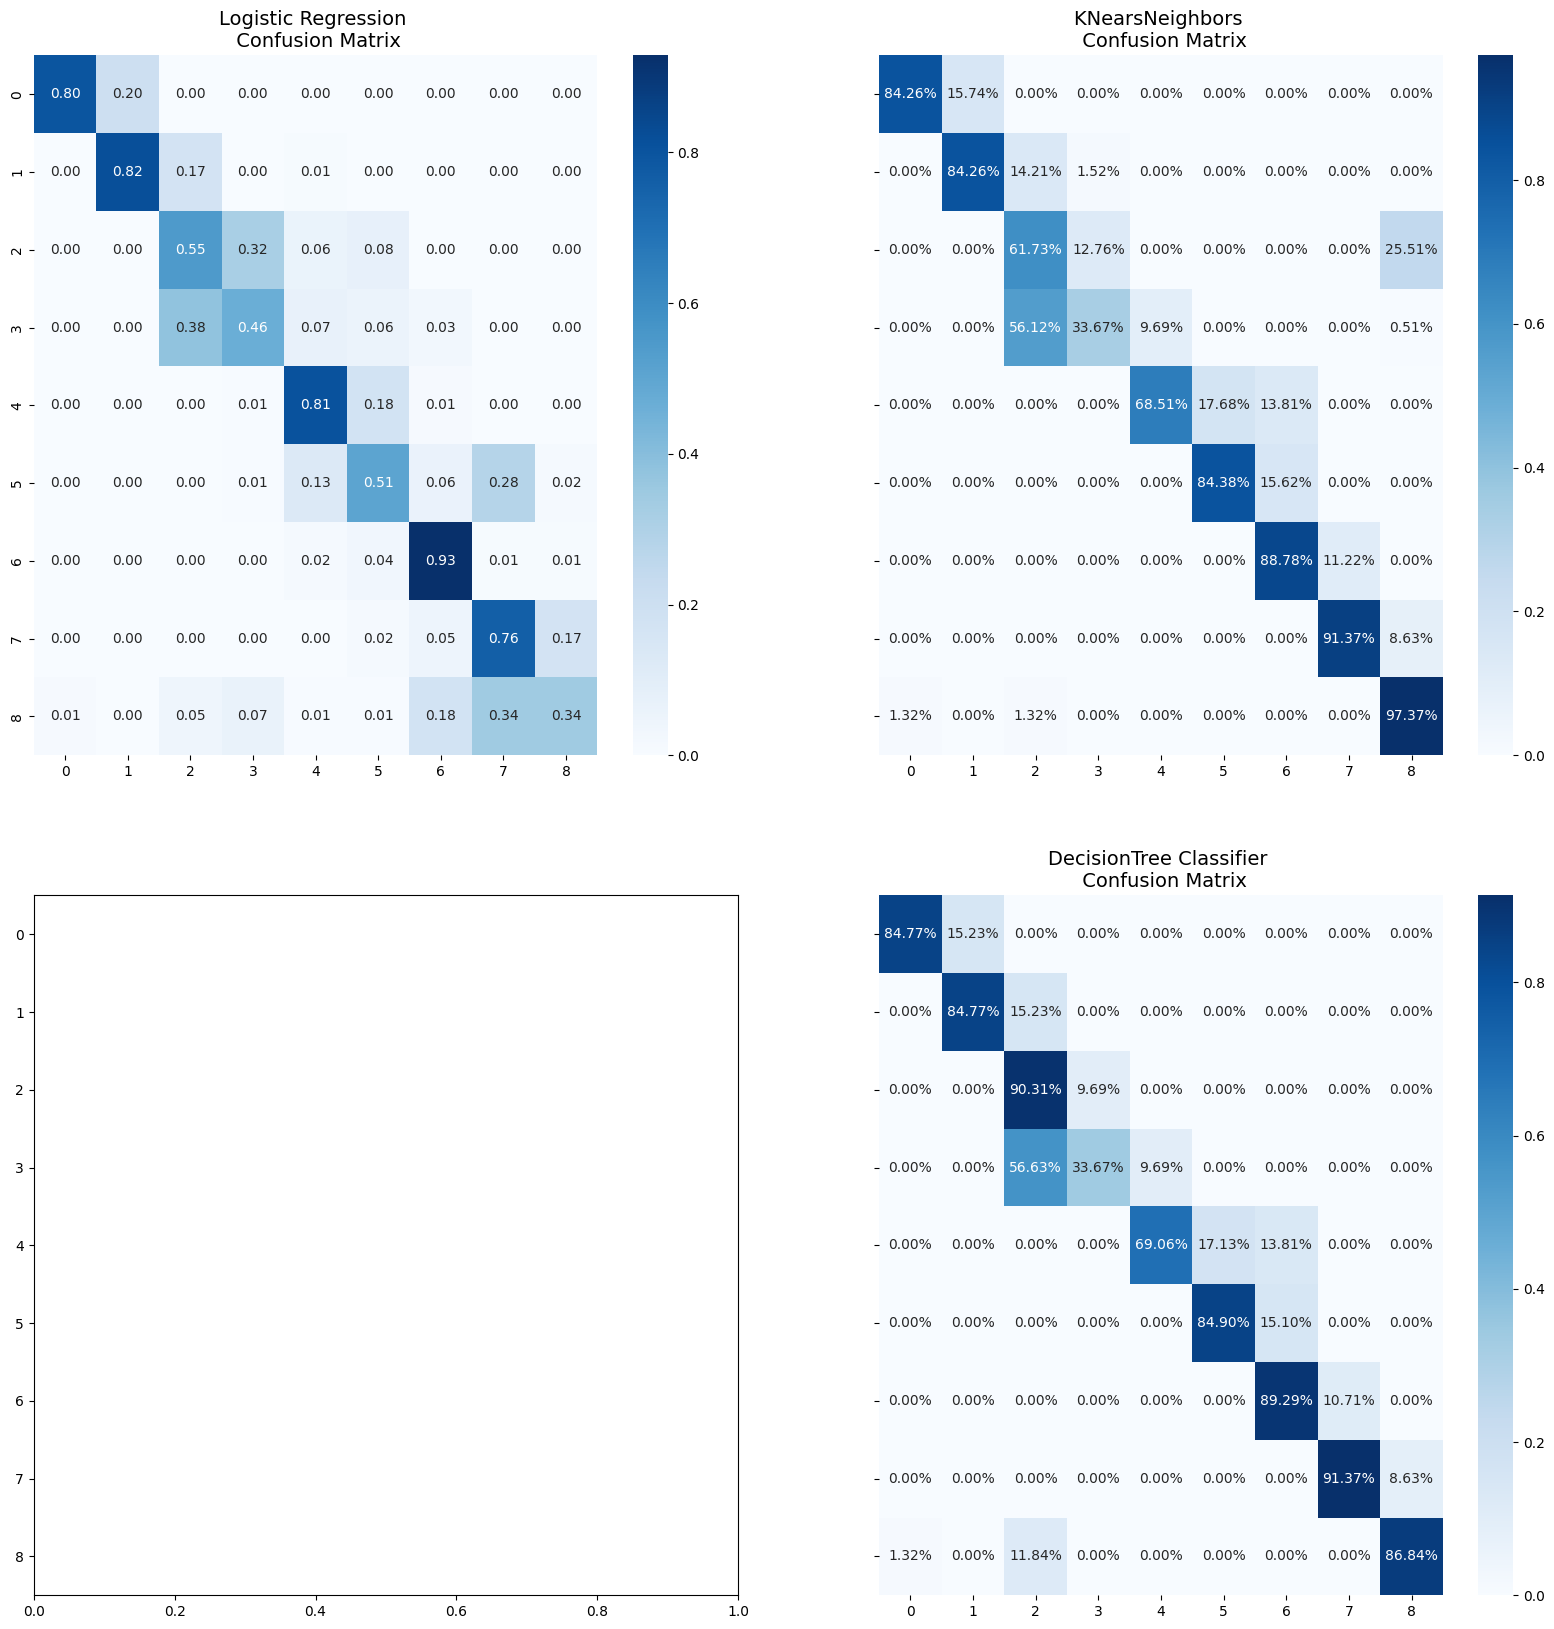

In [ ]:
y_pred_log_reg = best_est_LNR.predict(original_Xtest)

# Другие модели
y_pred_knear = best_est_KN.predict(original_Xtest)
y_pred_tree = best_est_CLF.predict(original_Xtest)


log_reg_cf = confusion_matrix(original_ytest, y_pred_log_reg, normalize='true')
kneighbors_cf = confusion_matrix(original_ytest, y_pred_knear, normalize='true')
tree_cf = confusion_matrix(original_ytest, y_pred_tree, normalize='true')

fig,  ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,20), sharey=True)
# Построим матрицы ошибок
sns.heatmap(ax=ax1, data=log_reg_cf, annot=True, fmt='.2f', cmap='Blues')
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)

#
sns.heatmap(ax=ax2,data=kneighbors_cf, annot=True, fmt='.2%', cmap='Blues')
ax2.set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)

#
sns.heatmap(ax=ax4, data=tree_cf, annot=True,
            fmt='.2%', cmap='Blues')
ax4.set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)


plt.show()

Выведем основные метрики моделей.

Давайте вспомним основные метрики качества классификации на примере нашей задачи:

* **Confusion matrix** : так же известна как матрица ошибок, состоит из 4 частей:

    * true positive (TP) : транзакция была мошеннической и модель предсказала ее как мошенническую
    * true negative (TN) : транзакция была нормальной и модель определила ее как нормальную
    * false positive (FP) : транзакция была нормальная, но модель среагировала на нее как на мошенническую
    * false negative (FN) : транзакция была мошенническая, но модель ее пропустила и посчитала нормальной


* **Метрики** :

    * Accuracy : (TP +TN) / (TP + TN + FP +FN)
    * Precision : TP / (TP + FP) (подходит при дисбалансе)
    * Recall : TP / (TP + FN) (подходит при дисбалансе)
    * F1 score : 2 x ((Precision x Recall) / (Precision + Recall)) (подходит при дисбалансе)

* **Roc-кривая** : ROC-кривая строится путем отрисовки графика зависимости частоты истинных положительных результатов (TPR) от частоты ложных положительных результатов (FPR) при различных пороговых значениях.

In [ ]:
from sklearn.metrics import classification_report



print('Logistic Regression:')
#
y_pred=  best_est_LNR.predict(original_Xtest)
print(classification_report(original_ytest, y_pred, target_names=labels))

print('KNears Neighbors:')
#
y_pred=  best_est_KN.predict(original_Xtest)
print(classification_report(original_ytest, y_pred, target_names=labels))

print('Decision Tree Classifier:')
#
y_pred=  best_est_CLF.predict(original_Xtest)
print(classification_report(original_ytest, y_pred, target_names=labels))



Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       197
           1       0.80      0.82      0.81       197
           2       0.48      0.55      0.51       196
           3       0.55      0.46      0.50       196
           4       0.72      0.81      0.76       181
           5       0.58      0.51      0.54       192
           6       0.76      0.93      0.84       196
           7       0.58      0.76      0.66       197
           8       0.57      0.34      0.43       152

    accuracy                           0.67      1704
   macro avg       0.67      0.66      0.66      1704
weighted avg       0.67      0.67      0.66      1704

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       197
           1       0.84      0.84      0.84       197
           2       0.46      0.62      0.53       196
           3       0.70      0.34      

Поскольку мы выбрали Decision Tree Classifier в качестве основной модели, давайте сравним ее качество в случае подхода under-sampling и в случае over-sampling.

In [ ]:
# Логистическая регрессия с under-sampling
y_pred = log_reg.predict(original_Xtest)
undersample_score = accuracy_score(original_ytest, y_pred)

# Логистическая регрессия с over-sampling
y_pred_sm = best_est_CLF.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Метод': ['Random Under-Sampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Метод,Score
0,Random Under-Sampling,0.703638
1,Oversampling (SMOTE),0.793427


Итак, в данной задаче более оптимальным подходом оказался Oversampling